# Opti Pipe

In [31]:
from opti_pipe import Model, Floor, Distributor,Node,NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter

Domain language

* inputs are always hot (outputs cooler)

In [32]:
config = load_config()

In [33]:
floor = Floor(config=config,corners=[(0,0),(0,5),(5,5),(5,0)])

distributor = Distributor(config=config,nodes=(
    Node(config,2.0,0,node_type=NodeType.INPUT),
    Node(config,2.2,0,node_type=NodeType.OUTPUT),
    Node(config,2.4,0,node_type=NodeType.INPUT),
    Node(config,2.6,0,node_type=NodeType.OUTPUT),
    Node(config,2.8,0,node_type=NodeType.INPUT),
    Node(config,3.0,0,node_type=NodeType.OUTPUT)),
    heat_per_node=1)

room_connections = (RoomConnection(config,output=Node(config,0,3.75,node_type=NodeType.OUTPUT),input=Node(config,0,3.5,node_type=NodeType.INPUT),heat_loss=0.8),
                    RoomConnection(config,output=Node(config,5,3,node_type=NodeType.OUTPUT),input=Node(config,5,3.25,node_type=NodeType.INPUT),heat_loss=0.5),
                    RoomConnection(config,output=Node(config,2.6,5,node_type=NodeType.OUTPUT),input=Node(config,2.4,5,node_type=NodeType.INPUT),heat_loss=0.3))


In [34]:
model = Model(
    config = config,
    target_heat_input=100,
    floor=floor,
    distributor=distributor,
    room_connections=room_connections)

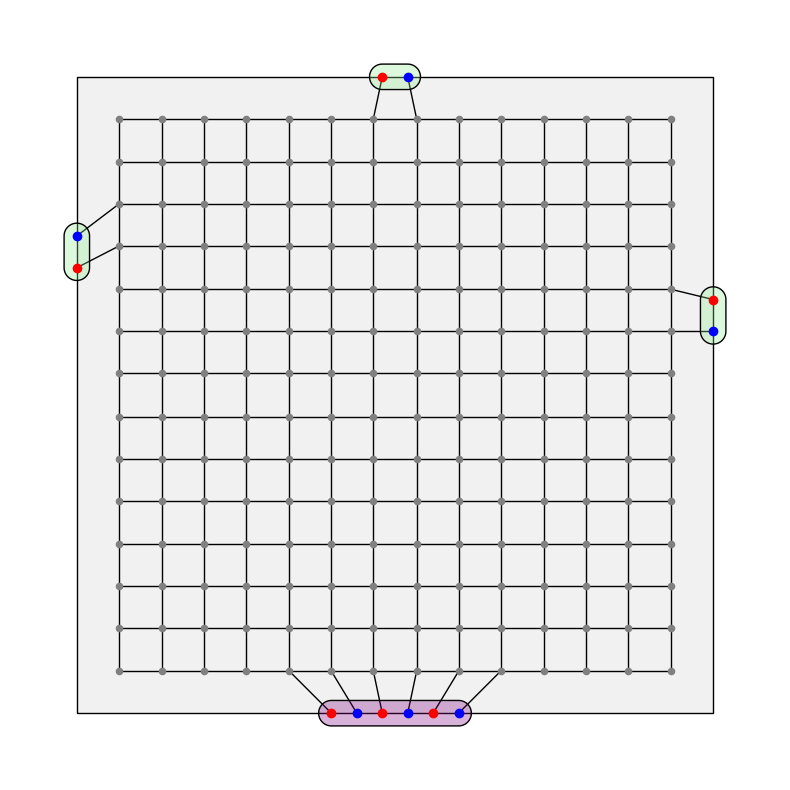

In [35]:

grid_size = 0.3
model.add_graph(grid_size)
model.render(show_graph=True)

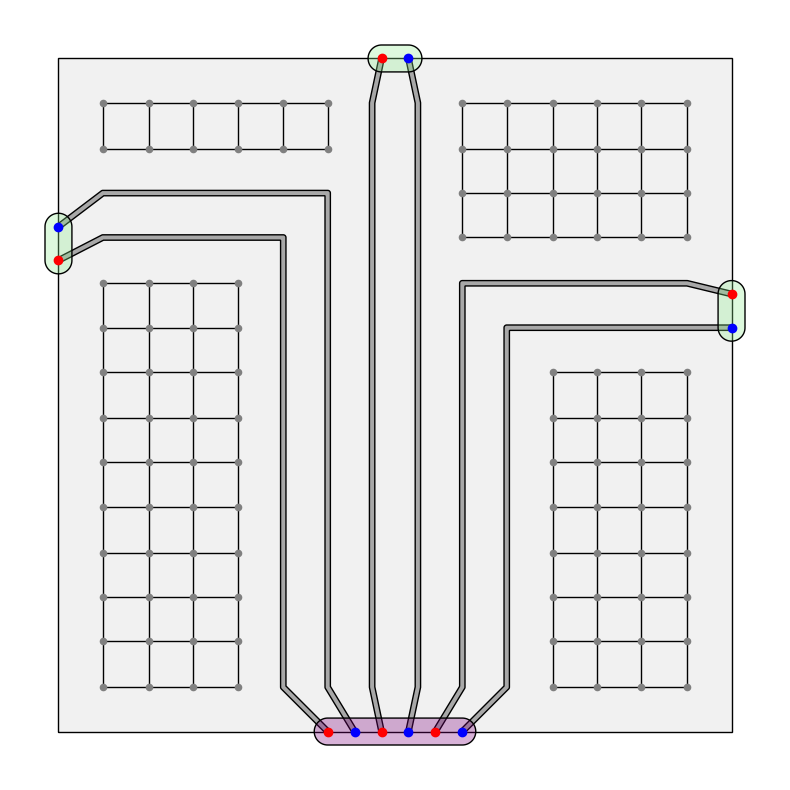

In [36]:
model.pipes = tuple()
router = NaiveRouter(config,model,grid_size)
model = router.route()
model.render(show_graph=True,render_heat_distribution=False) 

# from opti_pipe.router import Utils
# line_string = Utils.get_centerline(model,grid_size)
# from shapely.plotting import plot_polygon
# plot_polygon(line_string)

In [37]:
import networkx as nx
from shapely.geometry import MultiPoint
from shapely.plotting import  plot_points
subgraphs = tuple(nx.connected_components(model.graph.graph))

In [38]:
def get_multi_point_from_graph(graph,nodes):
    return MultiPoint([node.geometry for node in nodes if node.id in graph])
        
def find_best_pipe(subgraph,pipes,nodes,grid_size):
    shapely_points = get_multi_point_from_graph(subgraph,nodes)
    plot_points(shapely_points)
    potential_pipes = []
    for pipe in pipes:
        if pipe.geometry.distance(shapely_points) < grid_size*1.1:
            potential_pipes.append(pipe)
    if not potential_pipes:
        raise ValueError("No potential pipes found")
    best_pipe = max(potential_pipes,key=lambda x: x.heat)
    return best_pipe

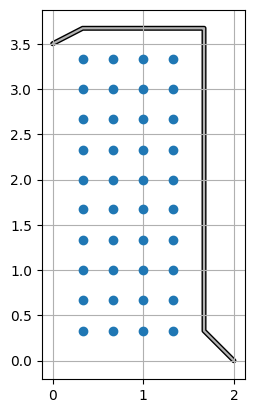

In [39]:
sg = subgraphs[0]
pipe = find_best_pipe(sg,model.pipes,model.graph.iter_nodes(),grid_size)
pipe._render()

In [75]:
def nodes_as_dict(nodes):
    for node in nodes:
        yield (node.id, {"x": node.x, "y": node.y})


def build_trav_graph(grid_size,pipe,subgraph):
    search_node_ids = tuple(subgraph | set(n.id for n in pipe.corners))
    _nodes = [n for n in model.graph.iter_nodes() if n.id in search_node_ids] + [pipe.input, pipe.output]
    g = nx.DiGraph()
    g.add_nodes_from(nodes_as_dict(_nodes))
    for i, node in enumerate(_nodes):
        for other_node in _nodes[:]:
            if node.id != other_node.id and node.is_neighbor(other_node, grid_size):
                g.add_edge(node.id, other_node.id)
    g.add_nodes_from(nodes_as_dict([pipe.input,pipe.output]))
    g.add_edge(pipe.input.id, pipe.corners[0].id)
    g.add_edge( pipe.corners[-1].id,pipe.output.id)
    return g

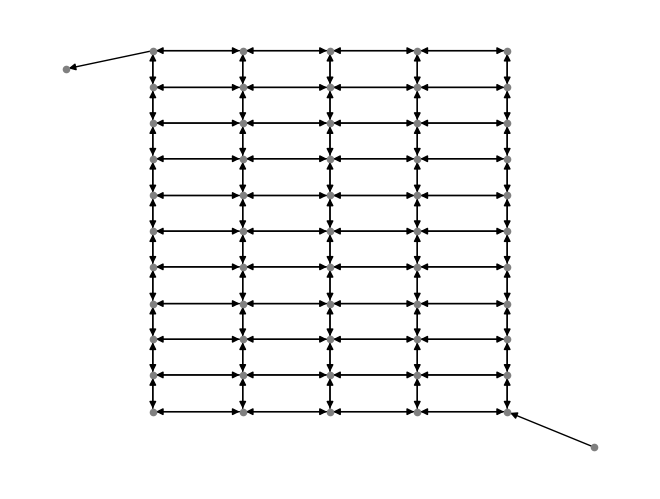

In [76]:
trav_graph = build_trav_graph(grid_size,pipe,sg)
#####################
search_node_ids = tuple(sg | set(n.id for n in pipe.corners))
_nodes = [n for n in model.graph.iter_nodes() if n.id in search_node_ids] + [pipe.input, pipe.output]
layout = {node.id: (node.x, node.y) for node in _nodes}
# for connector in self.connectors:
#     for node in connector.iter_nodes():
#         layout[node.id] = (node.x, node.y)
nx.draw(trav_graph, pos=layout, node_size=20, node_color="grey")


In [ ]:
from networkx.algorithms.approximation import traveling_salesman_problem,greedy_tsp,christofides
from opti_pipe.models import Pipe
from shapely.geometry import LineString
from shapely.plotting import plot_line
from functools import partial

# _greedy_tsp = partial(greedy_tsp, source=pipe.input.id)
# path = traveling_salesman_problem(trav_graph, cycle=False,method=christofides)

# print(path)
nodes = tuple(model.graph.nodes) + tuple([pipe.input, pipe.output]) + tuple(pipe.corners)
path_nodes = [next(filter(lambda x: x.id == node_id, nodes), None) for node_id in path]
path_line = LineString([node.geometry for node in path_nodes[:]])


nx.draw(trav_graph, pos=layout, node_size=20, node_color="grey")
plot_line(path_line, color="red", linewidth=2)


TypeError: all_simple_paths() got an unexpected keyword argument 'cuttoff'

In [49]:
pipe = Pipe.from_path(config, path_nodes, model.distributor)


ValueError: Path must have to nodes of type input or 2 nodes of type output